In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pystan
import arviz
from scipy import optimize

from src.preprocess_data import (
    create_df,
    process_train_df,
    get_id_to_rank,
    get_elo_df,
)

from src.utils import print_results, get_class_probs, get_stan_model

In [2]:
model_dir = "../stan_models/"
model_name = "ordered_logistic"

### Overview

We are going to fit an ordered logistic model which learns a per player ability rating.

### Train set

Let's load up the training set and transform it a little. The main thing we do is set it up as player 1 (P1) vs. player 2 (P2) rather than a single column always playing as either white or black - this is just a preference. 

In [3]:
df = create_df("../data/games.csv")

train = df.loc[df["date"] < "2019-01-01"]
train = process_train_df(train)

num_players = len(set(train["p1_id"].values).union(set(train["p2_id"].values)))
num_games = len(train)

We are going to learn a per player ability parameter and also use the training data to initially rank all the players based on their average Elo over the period in the training data. Whilst we are using the data to set a prior score this is fine as we are keeping a separate test set which we won't use at all for model fitting.

In [4]:
id_to_rank = get_id_to_rank(train)
ranked_ids = list(id_to_rank.keys())

We don't actually supply the model with a rank though, instead we transform it to a prior score - the higher the better ranked the player.

In [5]:
raw_prior_score = np.arange(num_players, 0, -1)
prior_score = (raw_prior_score - np.mean(raw_prior_score)) / (
    2 * np.std(raw_prior_score, ddof=1)
)
id_to_prior_score = {k: v for k, v in zip(ranked_ids, prior_score)}

Sort the training data based on the rank differences. This means the top of the training dataframe represents games with a big rank difference and those at the bottom expected close games. This is purely for ease of analysing the results afterwards.

In [6]:
train_sorted = train.sort_values(["abs_rank_diff", "p1_id"], ascending=[False, True])

### Test set

This section can safely be skipped.

A complexity of learning a per player ability rating is that at test time we might encounter players which were not in the training data but for whom we still need to make a prediction for (and have therefore not learned their ability).

We will need to handle 3 cases for the test set (433 games):

1. Both players were part of the train set (267 games).
2. Only one player was part of the train set (144 games).
3. Neither players were part of the train set (22 games).

Recall that the model likelihood is:

```
y[i] ~ ordered_logistic(a[player_1_rank[i]] - a[player_2_rank[i]] + w*player_1_white[i], c);

```

where the vector `a` represents the ability of each player composed as:

```
a = b * prior_score + sigma_a * raw_a;
``` 

in the [Stan model](../stan_models/ordered_logistic.stan).

In particular, we need to assign the players we haven't seen before a prior score (which is like ranking them). We will use their current Elo to give them a prior score roughly in line with how we converted Elo to prior score from the training data. So if a player has an Elo, of say, 2,850, that get them a prior score above the best ranked player in the training set as the maximum Elo in the training set is 2,827.

We can do this by looking, in the training set, at the relationship between Elo and prior score and using this functional form for the test set to get a prior score given an Elo.

If a player was part of the training set we will use the prior score they had then. If a player wasn't part of the training set we'll just use `b * prior_score` as their ability.

First we do a bit of prep work to figure out who in the test set was in the training data for each match.

In [7]:
test = df.loc[df["date"] >= "2019-01-01"]

test["p1_in_train"] = test["p1_id"].apply(lambda x: x in ranked_ids)
test["p2_in_train"] = test["p2_id"].apply(lambda x: x in ranked_ids)
test["both_p1_p2_in_train"] = test["p1_in_train"] & test["p2_in_train"]
test["one_of_p1_p2_in_train"] = (test["p1_in_train"] & ~test["p2_in_train"]) | (
    test["p2_in_train"] & ~test["p1_in_train"]
)
test["neither_p1_or_p2_in_train"] = ~test["p1_in_train"] & ~test["p2_in_train"]

In [8]:
train_elo_df = get_elo_df(train)
train_elo_df["prior_score"] = prior_score

Next we learn the functional form from Elo rating to prior score.

<ipython-input-9-a65d65caee74>:2: RuntimeWarning: overflow encountered in exp
  return (1 / (1 + np.exp(a * elo_centered)) - b) * c


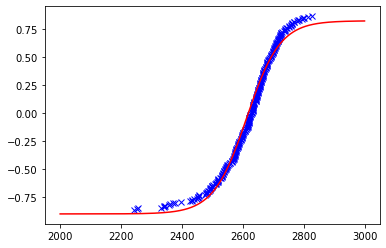

In [9]:
def get_prior_score_from_elo(elo_centered, a, b, c):
    return (1 / (1 + np.exp(a * elo_centered)) - b) * c


elo_mean = train_elo_df["elo"].values.mean()
x = train_elo_df["elo"].values - elo_mean
y = train_elo_df["prior_score"].values

params, _ = optimize.curve_fit(get_prior_score_from_elo, x, y)

t = np.linspace(2000, 3000, 1000)

plt.plot(x + elo_mean, y, "bx")
plt.plot(t, get_prior_score_from_elo(t - elo_mean, *params), "r-")
plt.show();

We can now assign a prior score to players who were not in the training set based on their Elo rating.

In [10]:
test["p1_prior_rank"] = 0
test["p2_prior_rank"] = 0

test.loc[test["p1_in_train"], "p1_prior_rank"] = test.loc[
    test["p1_in_train"], "p1_id"
].apply(lambda x: id_to_rank[x])
test.loc[test["p2_in_train"], "p2_prior_rank"] = test.loc[
    test["p2_in_train"], "p2_id"
].apply(lambda x: id_to_rank[x])

test["p1_prior_score"] = test["p1_elo"].apply(
    lambda x: get_prior_score_from_elo(x - elo_mean, *params)
)
test["p2_prior_score"] = test["p2_elo"].apply(
    lambda x: get_prior_score_from_elo(x - elo_mean, *params)
)

### Set-up model and fit

We center the priors for the two main parameters (`b` and `w`) at 0 even though we expect both to be positive.

In [11]:
model = get_stan_model(model_dir, model_name, load_compiled_model=True)

In [12]:
stan_data = {
    "num_players": num_players,
    "num_games": num_games,
    "K": 3,
    "prior_score": prior_score,
    "player_1_rank": train_sorted["p1_prior_rank"].values.astype(int),
    "player_2_rank": train_sorted["p2_prior_rank"].values.astype(int),
    "player_1_white": train_sorted["p1_white"].values.astype(int),
    "b_mu": 0.0,
    "b_scale": 0.5,
    "sigma_a_mu": 0.25,
    "sigma_a_scale": 0.5,
    "c_mu": np.array([-1.25, 1.25]),
    "c_scale": 0.5,
    "w_mu": 0,
    "w_scale": 0.25,
    "fit_model": 1,
    "y": train_sorted["p1_outcome"].values,
    # Predict on test set:
    "predict_on_test_set": 1,
    "num_test_games": len(test),
    "p1_in_train": test["p1_in_train"].values.astype(int),
    "p2_in_train": test["p2_in_train"].values.astype(int),
    "p1_test_rank": test["p1_prior_rank"].values.astype(int),
    "p2_test_rank": test["p2_prior_rank"].values.astype(int),
    "p1_test_prior_score": test["p1_prior_score"].values.astype(int),
    "p2_test_prior_score": test["p2_prior_score"].values.astype(int),
    "p1_test_white": test["p1_white"].values.astype(int),
}

In [13]:
fit = model.sampling(data=stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [20]:
params = fit.extract(permuted=True)

inference_data = arviz.convert_to_inference_data(fit)
summary_df = (
    arviz.summary(inference_data).reset_index().rename(columns={"index": "parameter"})
)

In [21]:
summary_df.head(5)

,parameter,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
0,b,1.109,0.079,0.962,1.257,0.001,0.001,4604.0,4511.0,4619.0,2732.0,1.0
1,w,0.618,0.089,0.457,0.793,0.001,0.001,5282.0,5059.0,5281.0,2849.0,1.0
2,c[0],-0.975,0.074,-1.110,-0.837,0.001,0.001,4544.0,4544.0,4527.0,2991.0,1.0
3,c[1],1.634,0.078,1.487,1.778,0.001,0.001,5002.0,4949.0,5018.0,3085.0,1.0
4,sigma_a,0.150,0.078,0.001,0.272,0.003,0.002,721.0,721.0,713.0,1024.0,1.0


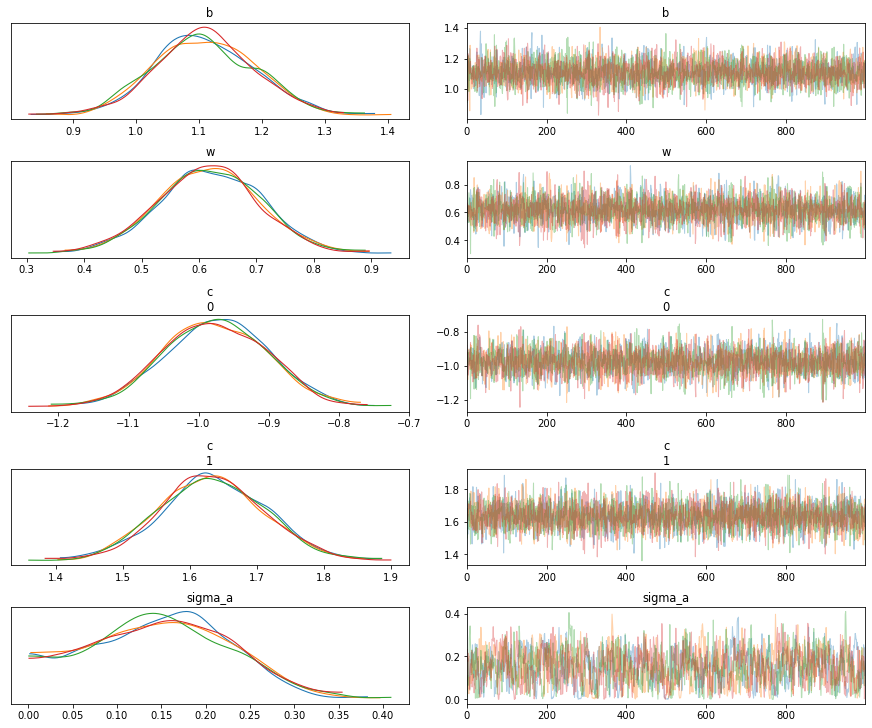

In [22]:
arviz.plot_trace(inference_data, var_names=["b", "w", "c", "sigma_a"], compact=False);

### Plotting

We can take a look at the learned relative abilities for players. We order them by their prior score (or ranking) from the training set. We see that the prior score is (expectedly) very informative and few players move much from it.

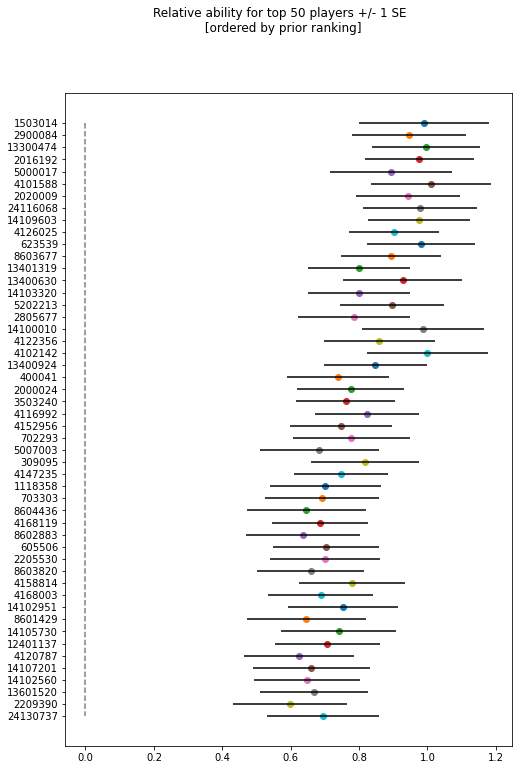

In [23]:
fig, ax = plt.subplots(figsize=(8, 12))
plot_top_n_players = 50

for i in range(plot_top_n_players):
    a_mean = params["a"][:, i].mean()
    a_sd = float(summary_df.loc[summary_df["parameter"] == f"a[{i}]", "sd"])
    ax.scatter(a_mean, i + 1)
    ax.hlines(i + 1, a_mean - a_sd, a_mean + a_sd)

plt.vlines(0, 1, plot_top_n_players, linestyle="--", alpha=0.5)
plt.gca().invert_yaxis()
plt.suptitle(
    f"Relative ability for top {plot_top_n_players} players +/- 1 SE \n [ordered by prior ranking]"
)
plt.yticks(range(1, plot_top_n_players + 1), ranked_ids[:plot_top_n_players]);

### Outcomes

We can also look at individual games and the probability distribution we predicted over the 3 outcomes (alongside the actual outcome, shown in red).

Recall that 1 means P1 lost, 2 is a draw and 3 means P1 won.

Setting `reverse=True` will plot the expected closer games.

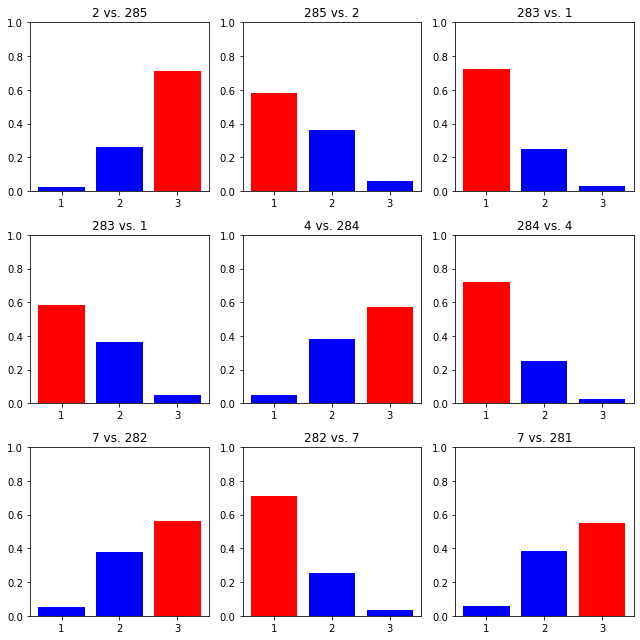

In [24]:
train_cls_probs = get_class_probs(params, "ypred")

plot_n = 9
reverse = False
colors = ["blue"] * 3

plot_df = (
    train_sorted
    if not reverse
    else train_sorted.sort_values(["abs_rank_diff", "p1_id"], ascending=[True, False])
)
ranks = [
    f"{a} vs. {b}"
    for a, b in zip(
        train_sorted["p1_prior_rank"].values.astype(int),
        train_sorted["p2_prior_rank"].values.astype(int),
    )
]
ranks = ranks[::-1] if reverse else ranks
train_cls_probs_plot = np.flip(train_cls_probs, 0) if reverse else train_cls_probs

fig, ax = plt.subplots(plot_n // 3, 3, figsize=(9, 9))
ax = ax.ravel()

for i in range(plot_n):
    bar_colors = colors.copy()
    bar_colors[plot_df["p1_outcome"].values[i] - 1] = "red"
    ax[i].bar(range(1, 4), train_cls_probs_plot[i, :], color=bar_colors)
    ax[i].set_title(f"{ranks[i]}")
    ax[i].set_ylim(0, 1)
plt.tight_layout();

### Accuracy on train set

We can calculate how accurate the model is at predicting the correct outcome. Given there are 3 outcomes we also note when the model was "out by one" i.e. a draw when it was a win/loss and "out by two" i.e. predicting a win when it was a loss or vice-versa.

In [25]:
cls_pred = np.argmax(train_cls_probs, 1) + 1

print_results(train_sorted, cls_pred, "Train", dp=4)

Train - exact: 0.5608, out by one: 0.4327, out by two: 0.0065


### Accuracy on test set

In [26]:
test_cls_probs = get_class_probs(params, "ypred_test")
cls_pred_test = np.argmax(test_cls_probs, 1) + 1
print_results(test, cls_pred_test, "Test both", dp=4)

Test both - exact: 0.5358, out by one: 0.4619, out by two: 0.0023
